In [0]:
import random
import torch
import torch.nn as nn
from torch import optim

RNN과 Seq2Seq의 차이

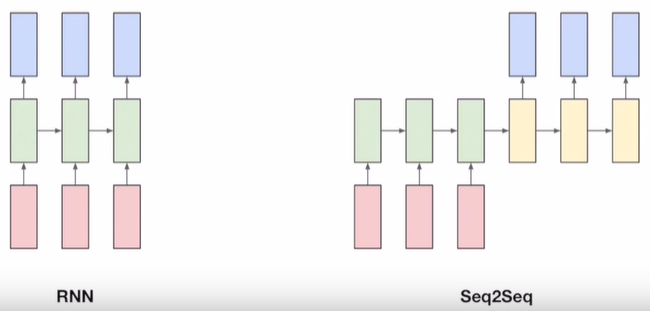

Seq2Seq 모델의 구성

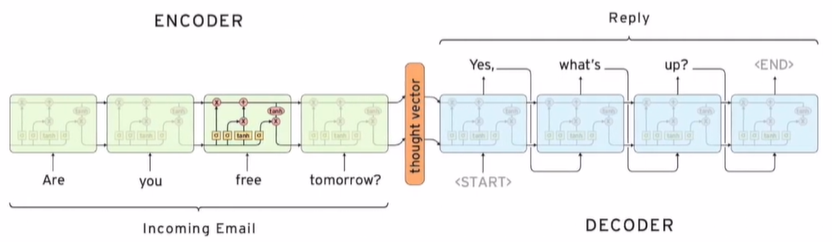

encoder부분에서 seq를 쭉 받아서 하나의 벡터로 만들고,
해당 hidden state값을 decoder 첫 값으로 넣어줌

rnn 두개를 만들어서 붙이는 것과 같은 방식!

In [0]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [0]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다.",
       "I am Hongki.	나는 홍기다.",
       "I am Kihun.	나는 기훈이다.",
       "Hongki love Pytorch.	홍기는 파이토치를 사랑한다.",
       "Kihun hate Pytorch.	기훈이는 파이토치를 싫어한다."]

In [0]:
# fix token for "start of sentence" and "end of sentence"
SOS_token = 0 # Start of Sentence
EOS_token = 1 # End of Sentence

In [0]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [0]:
# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [0]:
# read and preprocess the corpus data
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab() # 단어의 dictionary
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

In [0]:
# declare simple encoder. 보통은 attention이라던가... 다른 함수를 더 넣는다고 함
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) # 거대한 행렬에 해당. input: 들어오는 단어의 개수(각자는 one-hot 인코딩 되어있음). 
        self.gru = nn.GRU(hidden_size, hidden_size) # !!

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1) # embedding 행렬(단어개수*히든사이즈)과 input 행렬(1*단어개수)이 곱해져서 hidden-size 행렬(1*히든사이즈)이 나옴 
        x, hidden = self.gru(x, hidden)
        return x, hidden

gru

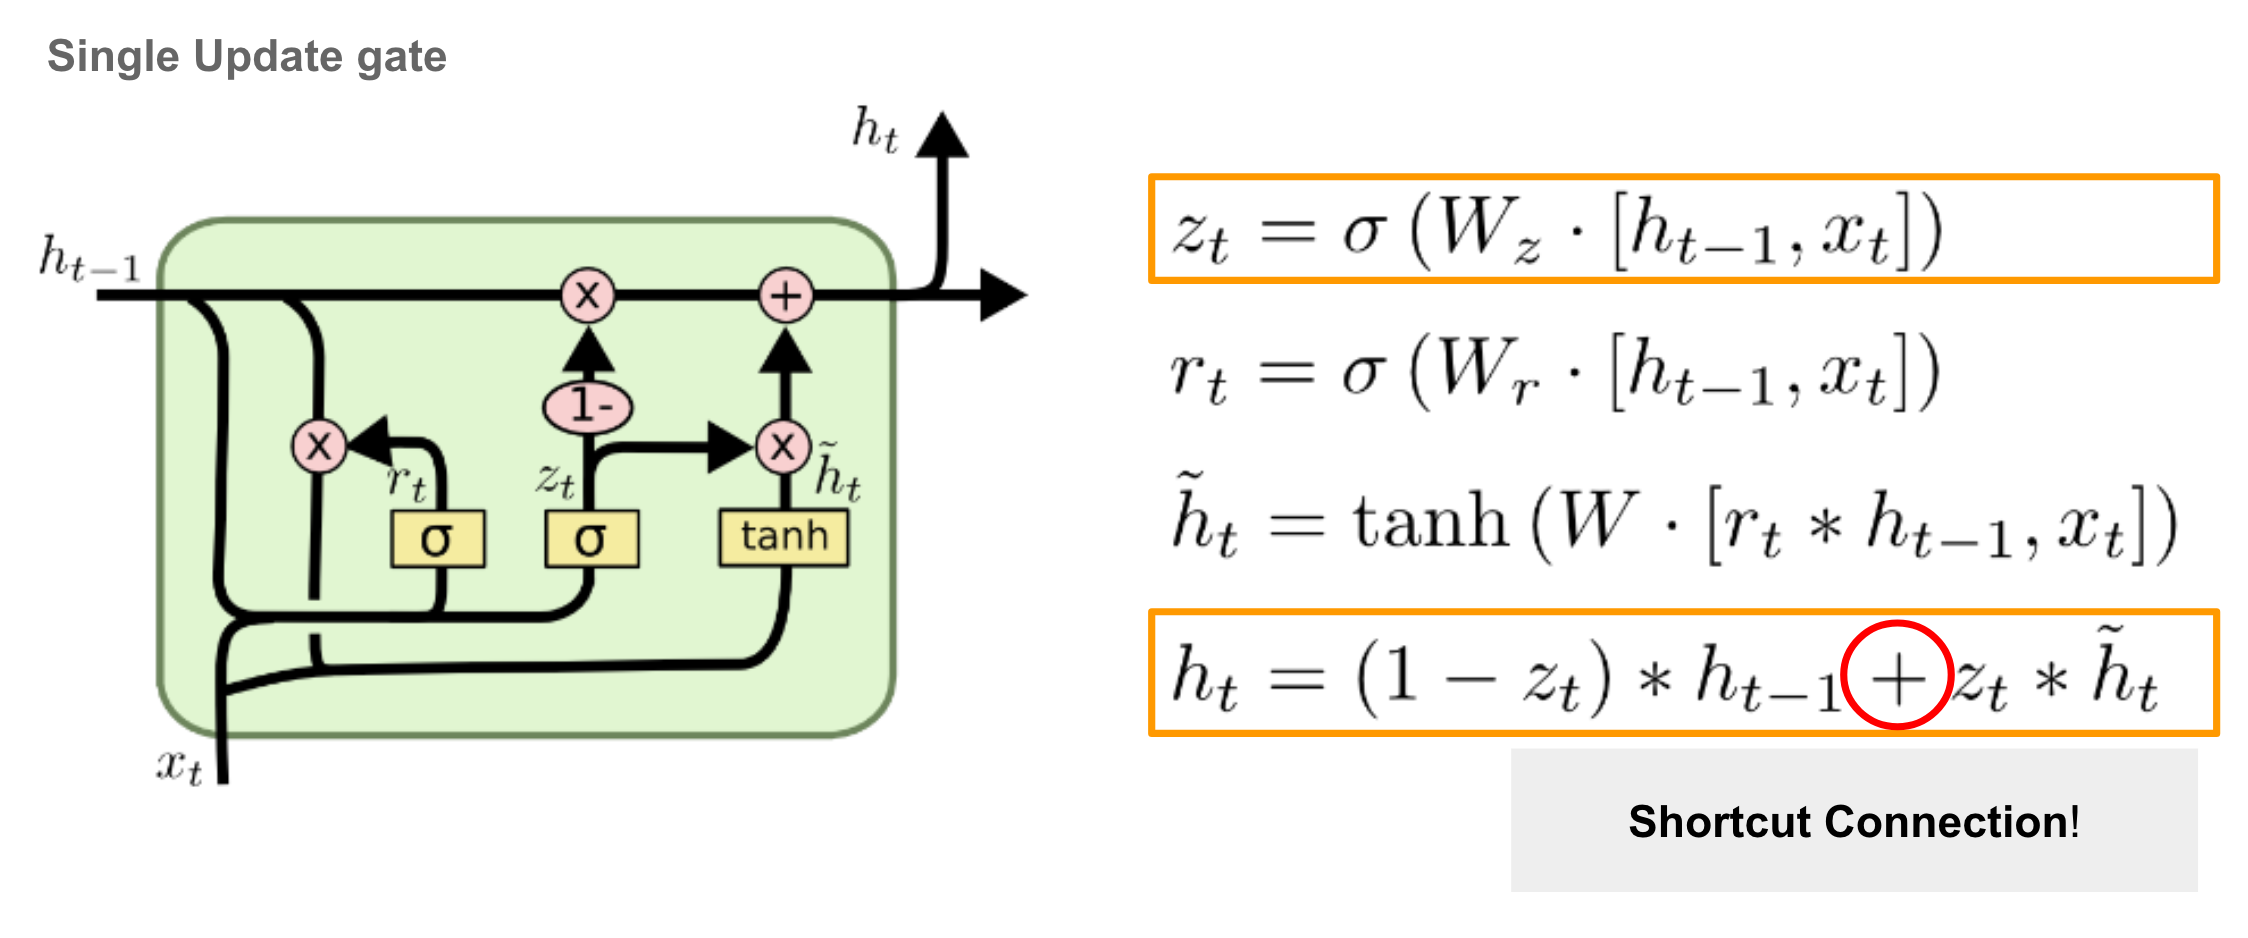

In [0]:
# declare simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0])) # 마지막에 단순 linier 추가. 히든사이즈를 아웃풋사이즈(=아웃풋단어개수)로 바꾸어줘야함
        return x, hidden

In [0]:
# 보조함수: sentence를 입력받아 one-hot vector(index tensor)로 바꿔주는 역할
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

In [0]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    # 데이터를 source, target으로 나눔...
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss() #Negative Log Likelihood. 카테고리 value를 다룰 때 자주 쓰임 (crossEntropy도 자주쓰임)

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device) # 첫 hidden state는 0으로 넣어줌

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length): # encoder로부터 hidden을 계속 뽑아냄
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden) 

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device) # 처음 input은 SOS
        decoder_hidden = encoder_hidden # encoder에서 나온 최종 hidden을 decoder 첫 hidden으로 사용

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing: decoder에서 나온 output을 다음 rnn의 input으로 사용하는 것이 아니라, 정답을 그대로 사용하는 것 (확률적으로 사용하는 경우도 있음)

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [0]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.cuda.FloatTensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

주의할점
torch.Tensor나 torch.FloatTensor는 GPU 지원을 안함!
GPU 상에서 사용하고싶다면 torch.cuda.FloatTensor를 사용해야 함.
* 참고: https://pytorch.org/docs/stable/tensors.html

In [0]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 20
TARGET_MAX_LENGTH = 30

In [0]:
# preprocess the corpus
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 8 sentence pairs
Trimmed to 8 sentence pairs
Counting words...
source vocab size = 25
target vocab size = 20
['i feel hungry.', '나는 배가 고프다.']


In [0]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [0]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 1.3149
[2000 - 40.0%] loss = 0.3536
[3000 - 60.0%] loss = 0.1966
[4000 - 80.0%] loss = 0.0960
[5000 - 100.0%] loss = 0.0492


In [0]:
raw2 = ["Love Hongki Pytorch.	파이토치를 사랑한다 홍기찡.",
       "Keras is very hungry.	케라스 매우 배고프다.",
       "Pytorch is Hongki.	파이토치는 홍기다.",
       "Wonsang hate Pytorch.	원상이는 파이토치를 싫어한다.",
       "Kihun love Pytorch.	기훈이는 파이토치를 사랑한다."]

In [0]:
# preprocess the corpus
load_pairs2, load_source_vocab2, load_target_vocab2 = preprocess(raw2, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs2))

reading corpus...
Read 5 sentence pairs
Trimmed to 5 sentence pairs
Counting words...
source vocab size = 14
target vocab size = 14
['kihun love pytorch.', '기훈이는 파이토치를 사랑한다.']


In [0]:
# check the model with given data
evaluate(load_pairs2, load_source_vocab2, load_target_vocab2, enc, dec, TARGET_MAX_LENGTH)

> love hongki pytorch.
= 파이토치를 사랑한다 홍기찡.
< 파이토치를 사랑한다 홍기찡. <EOS>

> keras is very hungry.
= 케라스 매우 배고프다.
< 케라스 매우 배고프다. <EOS>

> pytorch is hongki.
= 파이토치는 홍기다.
< 케라스 파이토치는 홍기다. 원상이는 <EOS>

> wonsang hate pytorch.
= 원상이는 파이토치를 싫어한다.
< 파이토치를 사랑한다 홍기찡. <EOS>

> kihun love pytorch.
= 기훈이는 파이토치를 사랑한다.
< 파이토치를 사랑한다 홍기찡. <EOS>

